In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/Users/sarayu.madakasira/Downloads/data.csv")
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [3]:
df.drop(['country'], axis=1, inplace=True)

In [4]:
def min_max_scaling(data, feature_range=(0, 1)):
    data_min = np.min(data, axis=0)  
    data_max = np.max(data, axis=0)  
    scale_min, scale_max = feature_range
    
    scaled_data = (data - data_min) / (data_max - data_min) * (scale_max - scale_min) + scale_min
    
    return scaled_data
    
df = min_max_scaling(df, feature_range=(0, 1))
print("Scaled Data:\n", df)

Scaled Data:
      child_mort   exports    health   imports    income  inflation  \
0      0.426485  0.049482  0.358608  0.257765  0.008047   0.126144   
1      0.068160  0.139531  0.294593  0.279037  0.074933   0.080399   
2      0.120253  0.191559  0.146675  0.180149  0.098809   0.187691   
3      0.566699  0.311125  0.064636  0.246266  0.042535   0.245911   
4      0.037488  0.227079  0.262275  0.338255  0.148652   0.052213   
..          ...       ...       ...       ...       ...        ...   
162    0.129503  0.232582  0.213797  0.302609  0.018820   0.063118   
163    0.070594  0.142032  0.192666  0.100809  0.127750   0.463081   
164    0.100779  0.359651  0.312617  0.460715  0.031200   0.150725   
165    0.261441  0.149536  0.209447  0.197397  0.031120   0.257000   
166    0.391918  0.184556  0.253574  0.177275  0.021473   0.168284   

     life_expec  total_fer      gdpp  
0      0.475345   0.736593  0.003073  
1      0.871795   0.078864  0.036833  
2      0.875740   0.274448  

In [5]:
df = df.to_numpy()

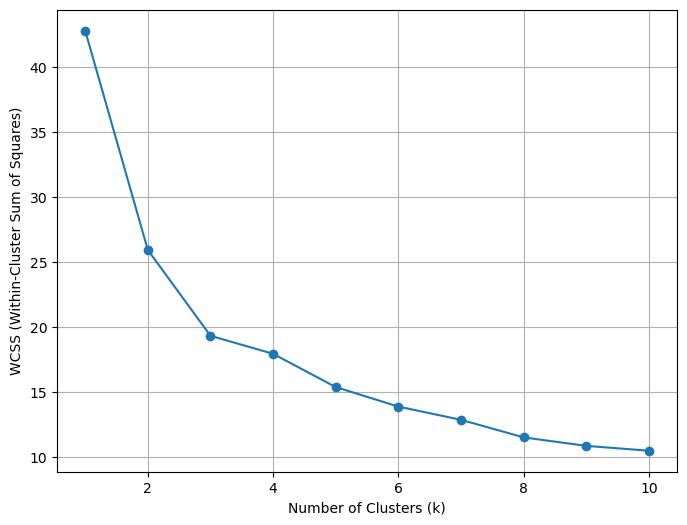

In [6]:
class KMeans:
    def __init__(self, k, max_iters=100, tol=1e-4):
        self.k = k
        self.max_iters = max_iters
        self.tol = tol

    def fit(self, data):
        np.random.seed(42)
        random_indices = np.random.choice(data.shape[0], self.k, replace=False)
        self.centroids = data[random_indices]
        
        for i in range(self.max_iters):
            self.labels = self._assign_clusters(data)
            new_centroids = np.array([data[self.labels == j].mean(axis=0) for j in range(self.k)])
            
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            
            self.centroids = new_centroids

    def _assign_clusters(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def predict(self, data):
        return self._assign_clusters(data)

    def inertia(self, data):
        distances = np.linalg.norm(data[:, np.newaxis] - self.centroids, axis=2)
        closest_cluster_distances = np.min(distances, axis=1)
        return np.sum(closest_cluster_distances**2)



wcss = []
for k in range(1, 11):  
    kmeans = KMeans(k=k)
    kmeans.fit(df)  
    wcss.append(kmeans.inertia(df))  

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()


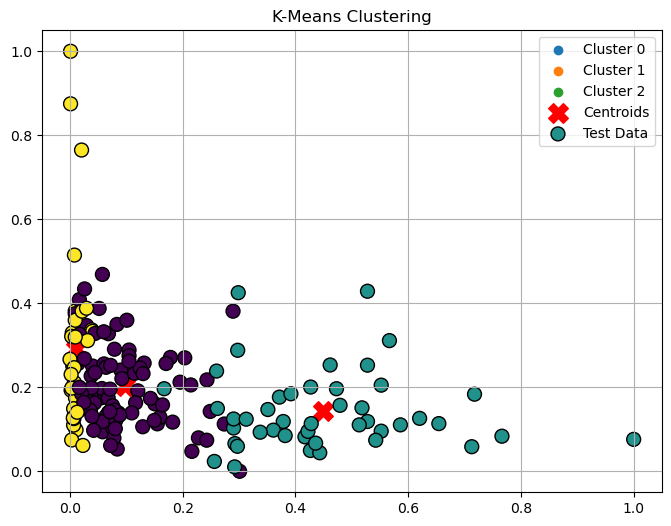

In [7]:
# Perform K-Means clustering
kmeans = KMeans(k=3)
kmeans.fit(df)


test_labels = kmeans.predict(df)
df_new = pd.DataFrame(df, columns=['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp'])
df_new['Cluster_Labels'] = test_labels

plt.figure(figsize=(8, 6))

for cluster in range(kmeans.k):
    cluster_points = df[kmeans.labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], s=200, c='red', marker='X', label='Centroids')

plt.scatter(df[:, 0], df[:, 1], c=test_labels, marker='o', edgecolor='k', s=100, label='Test Data')

plt.title("K-Means Clustering")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def silhouette_score(data, labels):
    unique_labels = np.unique(labels)
    n_samples = data.shape[0]
    
    silhouette_scores = []
    
    for i in range(n_samples):
        same_cluster_points = data[labels == labels[i]]
        a_i = np.mean(np.linalg.norm(same_cluster_points - data[i], axis=1))
        other_clusters_points = [data[labels == label] for label in unique_labels if label != labels[i]]
        b_i = np.min([np.mean(np.linalg.norm(cluster - data[i], axis=1)) for cluster in other_clusters_points])
        silhouette_scores.append((b_i - a_i) / max(a_i, b_i))
    return np.mean(silhouette_scores)


labels = kmeans.labels 
sil_score = silhouette_score(df, labels)
print(f"Silhouette Score: {sil_score:.4f}")


Silhouette Score: 0.3520


In [9]:
print(f"Inertia (WCSS) for k=3: {kmeans.inertia(df)}")

Inertia (WCSS) for k=3: 19.35198252576052


In [10]:
def dunn_index(data, labels, centroids):
    k = len(centroids)
    
    def centroid_distance(i, j):
        return np.linalg.norm(centroids[i] - centroids[j])
    
    def cluster_diameter(cluster_points):
        max_distance = 0
        for i in range(len(cluster_points)):
            for j in range(i + 1, len(cluster_points)):
                dist = np.linalg.norm(cluster_points[i] - cluster_points[j])
                max_distance = max(max_distance, dist)
        return max_distance

    min_inter_cluster_distance = float('inf')
    max_intra_cluster_diameter = float('-inf')
    
    for i in range(k):
        cluster_i_points = data[labels == i]
        
        max_intra_cluster_diameter = max(max_intra_cluster_diameter, cluster_diameter(cluster_i_points))
        
        for j in range(i + 1, k):
            cluster_j_points = data[labels == j]
            
            min_inter_cluster_distance = min(min_inter_cluster_distance, centroid_distance(i, j))
    
    return min_inter_cluster_distance / max_intra_cluster_diameter


kmeans = KMeans(k=3)  
kmeans.fit(df)
labels = kmeans.labels
centroids = kmeans.centroids

dunn = dunn_index(df, labels, centroids)
print(f"Dunn Index: {dunn}")

Dunn Index: 0.3275656635078212


In [11]:
df_new

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Cluster_Labels
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073,1
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833,0
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365,0
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488,1
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242,0
...,...,...,...,...,...,...,...,...,...,...
162,0.129503,0.232582,0.213797,0.302609,0.018820,0.063118,0.609467,0.370662,0.026143,0
163,0.070594,0.142032,0.192666,0.100809,0.127750,0.463081,0.854043,0.208202,0.126650,0
164,0.100779,0.359651,0.312617,0.460715,0.031200,0.150725,0.808679,0.126183,0.010299,0
165,0.261441,0.149536,0.209447,0.197397,0.031120,0.257000,0.698225,0.555205,0.010299,1


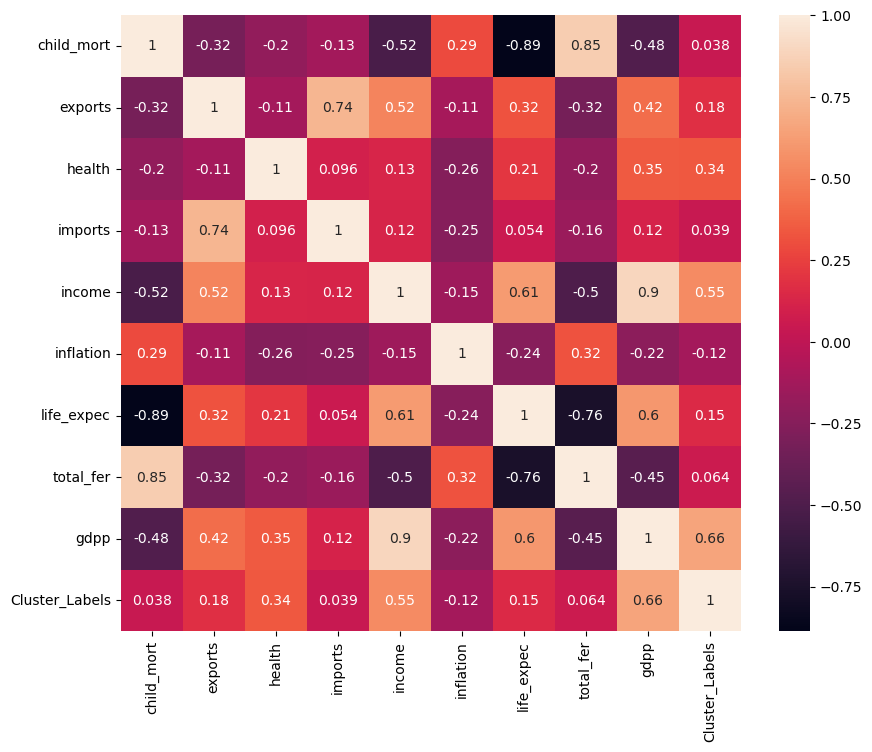

In [12]:
corr_matrix = df_new.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [13]:
df_new.drop(['child_mort'], axis=1, inplace=True)
df_new.drop(['imports'], axis=1, inplace=True)
df_new.drop(['total_fer'], axis=1, inplace=True)

In [14]:
y = df_new['Cluster_Labels']
x = df_new.drop(['Cluster_Labels'], axis=1)
x

,exports,health,income,inflation,life_expec,gdpp
0,0.049482,0.358608,0.008047,0.126144,0.475345,0.003073
1,0.139531,0.294593,0.074933,0.080399,0.871795,0.036833
2,0.191559,0.146675,0.098809,0.187691,0.875740,0.040365
3,0.311125,0.064636,0.042535,0.245911,0.552268,0.031488
4,0.227079,0.262275,0.148652,0.052213,0.881657,0.114242
...,...,...,...,...,...,...
162,0.232582,0.213797,0.018820,0.063118,0.609467,0.026143
163,0.142032,0.192666,0.127750,0.463081,0.854043,0.126650
164,0.359651,0.312617,0.031200,0.150725,0.808679,0.010299
165,0.149536,0.209447,0.031120,0.257000,0.698225,0.010299


In [15]:
ratio = 0.75
total_rows = df_new.shape[0]
train_size = int(total_rows*ratio)
x_train = x[0:train_size]
x_test = x[train_size:]
y_train = y[0:train_size]
y_test = y[train_size:]

In [16]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [17]:
from collections import Counter
from math import sqrt

def euclidean_distance(point1, point2):
    return sqrt(np.sum((point1 - point2) ** 2))

class KNN:
    def __init__(self, k=2):
        self.k = k 

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return np.array(predictions)
        
    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
        
        k_indices = np.argsort(distances)[:self.k]
        
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [18]:
knn = KNN(k=2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(y_pred)
print("-----")
print(y_test)

[0 1 0 0 1 0 0 1 2 2 2 0 0 2 2 0 0 0 0 2 2 0 1 0 0 1 0 0 0 0 1 1 2 2 2 0 0
 0 0 0 1 1]
-----
[0 1 0 0 1 0 0 1 2 2 2 0 0 2 2 0 0 1 0 2 2 0 1 0 1 1 0 0 0 0 1 0 2 2 2 0 0
 0 0 0 1 1]


In [19]:
from collections import Counter
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision(y_true, y_pred, positive_class):
    tp = np.sum((y_pred == positive_class) & (y_true == positive_class))
    fp = np.sum((y_pred == positive_class) & (y_true != positive_class))
    return tp / (tp + fp) if (tp + fp) != 0 else 0

def recall(y_true, y_pred, positive_class):
    tp = np.sum((y_pred == positive_class) & (y_true == positive_class))
    fn = np.sum((y_pred != positive_class) & (y_true == positive_class))
    return tp / (tp + fn) if (tp + fn) != 0 else 0

def f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

In [20]:
acc = accuracy(y_test, y_pred)
prec = precision(y_test, y_pred, positive_class=1)
rec = recall(y_test, y_pred, positive_class=1)
f1 = f1_score(prec, rec)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9286
Precision: 0.8889
Recall: 0.8000
F1 Score: 0.8421
